# Sheet02 Solution

Group members - 
1. Aayush Manoj Tirmalle (Matrikel nummer - 4730148)
2. Joshua Ulrich Mulihigoa Mauligalo (Matrikel nummer - )


###  1. Uniform Manifold Approximation and Projection

In [1]:
# Step 1: Load jet data (high-dimensional)",    
import numpy as np
data = np.load('../sheet01/data/dijet_features.npy')
print('Jet data shape:', data.shape)
N = data.shape[0]

Jet data shape: (116, 2233)


In [2]:
# Step 2: Build symmetrized kNN graph
from sklearn.neighbors import NearestNeighbors
k = min(15, N)
nn = NearestNeighbors(n_neighbors=k, algorithm='auto').fit(data)
distances, indices = nn.kneighbors(data)

# Step 3: Extract edges
edges = set()
for i in range(N):
    for j in indices[i]:
        if i != j:
            edges.add(tuple(sorted((i, j))))
edges = list(edges)
print(f'Number of edges in symmetrized kNN graph: {len(edges)}')
print('Sample edges:', edges[:10])

Number of edges in symmetrized kNN graph: 1248
Sample edges: [(13, np.int64(88)), (32, np.int64(101)), (np.int64(24), 97), (17, np.int64(58)), (np.int64(76), 107), (17, np.int64(94)), (np.int64(77), 108), (6, np.int64(84)), (np.int64(39), 81), (62, np.int64(101))]


In [3]:
# Step 4: Force-directed layout using gradient descent (UMAP)
np.random.seed(42)
Z_umap = np.random.randn(N, 2)
c = 10
num_random_pairs = 5 * N
learning_rate = 1.0
min_lr = 0.01
num_iters = 200
for it in range(num_iters):
    grad = np.zeros_like(Z_umap)
    # Attractive forces
    for i, j in edges:
        diff = Z_umap[i] - Z_umap[j]
        d2 = np.sum(diff**2)
        grad[i] += 2 * diff / (1 + d2)
        grad[j] -= 2 * diff / (1 + d2)
    # Repulsive forces (resampled each iteration)
    rand_pairs = np.random.choice(N, (num_random_pairs, 2), replace=True)
    for i, j in rand_pairs:
        if i == j: continue
        diff = Z_umap[i] - Z_umap[j]
        d2 = np.sum(diff**2)
        grad[i] -= 2 * c * diff / (1 + d2)**2
        grad[j] += 2 * c * diff / (1 + d2)**2
    Z_umap -= learning_rate * grad / N
    learning_rate = max(min_lr, learning_rate * 0.98)
    if it % 20 == 0:
        print(f'Iteration {it}, learning rate: {learning_rate:.4f}')
        print('UMAP embedding shape:', Z_umap.shape)

Iteration 0, learning rate: 0.9800
UMAP embedding shape: (116, 2)

UMAP embedding shape: (116, 2)
Iteration 20, learning rate: 0.6543
UMAP embedding shape: (116, 2)
Iteration 20, learning rate: 0.6543
UMAP embedding shape: (116, 2)
Iteration 40, learning rate: 0.4368
UMAP embedding shape: (116, 2)
Iteration 40, learning rate: 0.4368
UMAP embedding shape: (116, 2)
Iteration 60, learning rate: 0.2916
UMAP embedding shape: (116, 2)
Iteration 60, learning rate: 0.2916
UMAP embedding shape: (116, 2)
Iteration 80, learning rate: 0.1947
UMAP embedding shape: (116, 2)
Iteration 80, learning rate: 0.1947
UMAP embedding shape: (116, 2)
Iteration 100, learning rate: 0.1300
UMAP embedding shape: (116, 2)
Iteration 100, learning rate: 0.1300
UMAP embedding shape: (116, 2)
Iteration 120, learning rate: 0.0868
UMAP embedding shape: (116, 2)
Iteration 120, learning rate: 0.0868
UMAP embedding shape: (116, 2)
Iteration 140, learning rate: 0.0579
UMAP embedding shape: (116, 2)
Iteration 140, learning ra

PCA embedding shape: (116, 2)


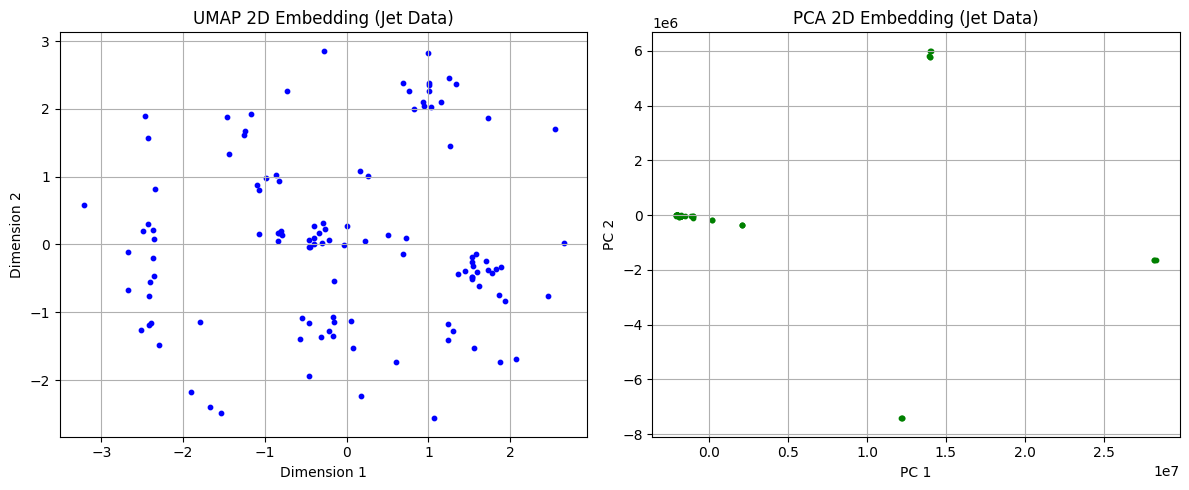

In [4]:
# Step 5: Compare with PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
Z_pca = pca.fit_transform(data)
print('PCA embedding shape:', Z_pca.shape)

# Visualize UMAP and PCA embeddings
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(Z_umap[:,0], Z_umap[:,1], c='blue', s=10)
plt.title('UMAP 2D Embedding (Jet Data)')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True)
plt.subplot(1,2,2)
plt.scatter(Z_pca[:,0], Z_pca[:,1], c='green', s=10)
plt.title('PCA 2D Embedding (Jet Data)')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.grid(True)
plt.tight_layout()
plt.show()

###  2. Kernel Density Estimation


#### (a) Effect of Bandwidth on KDE

The density estimate using an RBF kernel is:

$$
k(x) = \frac{1}{w\sqrt{2\pi}} \sum_{n=1}^N \exp\left(-\frac{(x - x_n)^2}{2w^2}\right)
$$

- **Very small bandwidth ($w \ll 1$):** Each kernel is very narrow, so the density estimate will show sharp peaks at each data point and be nearly zero elsewhere. The result is a spiky, overfit density.
- **Very large bandwidth ($w \gg 1$):** Each kernel is very wide, so the density estimate will be very smooth and may miss important features of the data, possibly resembling a broad Gaussian.
- **Recommended bandwidth for this dataset:** Typically, a value close to the average distance between neighboring points works well. For the provided data, a reasonable choice is the standard deviation of the data divided by $\sqrt{N}$, or use cross-validation to select $w$.

Bandwidth 0.05: kde shape = (500,), x_grid shape = (500,)
Bandwidth 0.2: kde shape = (500,), x_grid shape = (500,)
Bandwidth 1.0: kde shape = (500,), x_grid shape = (500,)


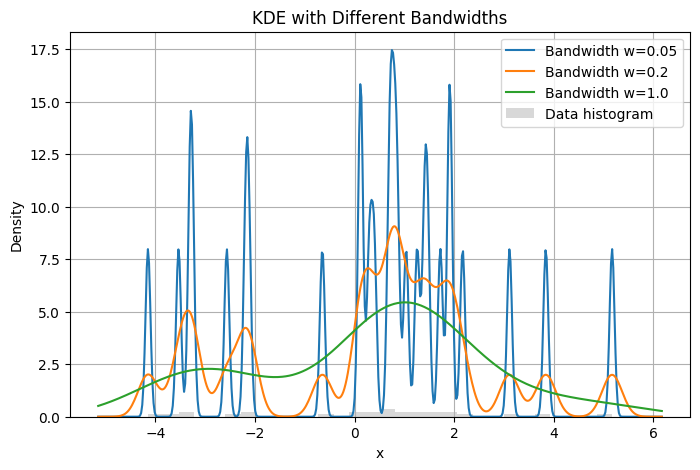

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Load 1D data
data = np.load('data/kde_1d_data.npy')
N = data.shape[0]
x_grid = np.linspace(data.min()-1, data.max()+1, 500)

# KDE function
def kde_rbf(x_grid, data, w):
    x_grid = np.asarray(x_grid).reshape(-1)
    data = np.asarray(data).reshape(-1)
    result = np.sum(np.exp(-(x_grid[:,None] - data[None,:])**2 / (2*w**2)), axis=1) / (N * w * np.sqrt(2*np.pi))
    return result

bandwidths = [0.05, 0.2, 1.0]
plt.figure(figsize=(8,5))
for w in bandwidths:
    kde = kde_rbf(x_grid, data, w)
    print(f"Bandwidth {w}: kde shape = {kde.shape}, x_grid shape = {x_grid.shape}")
    plt.plot(x_grid, kde, label=f'Bandwidth w={w}')
plt.hist(data.flatten(), bins=30, density=True, alpha=0.3, color='gray', label='Data histogram')
plt.title('KDE with Different Bandwidths')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

#### (b) Scheme to Adjust Bandwidth Locally

A common approach is to use **adaptive bandwidth**:
- For each data point $x_n$, set its bandwidth $w_n$ proportional to the local density (e.g., the distance to its $k$-th nearest neighbor).
- Pseudocode:

```python
for each data point x_n:
    w_n = distance to k-th nearest neighbor of x_n
```
- This makes the kernel wider in sparse regions and narrower in dense regions, improving the KDE estimate.

#### (c) Bonus: KDE with Fast Fourier Transform (FFT)

**Description:**
- For large 1D datasets, KDE can be computed efficiently by convolving the data histogram with the kernel using FFT.
- Steps:
    1. Bin the data into a histogram.
    2. Compute the kernel values on the same grid.
    3. Use FFT to convolve the histogram and kernel.

**Pseudocode:**
```python
hist = histogram(data, bins)
kernel = gaussian_kernel(grid, bandwidth)
kde = fft_convolve(hist, kernel)
```

**High-dimensional data:**
- FFT-based KDE does **not** scale well to high dimensions because the grid size grows exponentially (curse of dimensionality).
- For high-dimensional data, direct evaluation or tree-based methods are preferred.

### 3. Linear Regression: $\sigma^2$ Estimation and Heteroscedastic Noise

#### (a) Maximum Likelihood Estimation for $\beta$ and $\sigma^2$

Given the linear regression model:
$$
y_n = \beta^T x_n + \epsilon_n
$$
where $\epsilon_n \sim \mathcal{N}(0, \sigma^2)$, the likelihood for $N$ data points is:
$$
p(y_n | \beta, \sigma^2) = \mathcal{N}(y_n | \beta^T x_n, \sigma^2)
$$

##### Step 1: Estimate $\beta$ by maximizing the log-likelihood
$$
\hat{\beta} = \arg\max_{\beta} \sum_{n=1}^N \log \mathcal{N}(y_n | \beta^T x_n, \sigma^2)
$$
This is equivalent to minimizing the sum of squared residuals (SSQ):
$$
\hat{\beta} = \arg\min_{\beta} \sum_{n=1}^N (y_n - \beta^T x_n)^2
$$

##### Step 2: Estimate $\sigma^2$ by maximizing the log-likelihood given $\hat{\beta}$
$$
\hat{\sigma}^2 = \arg\max_{\sigma^2} \sum_{n=1}^N \log \mathcal{N}(y_n | \hat{\beta}^T x_n, \sigma^2)
$$
This leads to:
$$
\hat{\sigma}^2 = \frac{1}{N} \sum_{n=1}^N (y_n - \hat{\beta}^T x_n)^2
$$

**Relation to SSQ:**
- The maximum likelihood estimate of $\sigma^2$ is the mean of the squared residuals (the SSQ divided by $N$).
- This matches the result from the lecture: the variance estimate is the average squared error after fitting $\beta$.


#### (b) Heteroscedastic Noise: Weighted Least Squares and Mean Structure of $\hat{\beta}$

**Question Recap:**
- In standard linear regression, the noise variance is constant (homoscedastic).
- In the heteroscedastic case, each data point $n$ has its own variance $\sigma_n^2$:
  $$
  y_n = \beta^T x_n + \epsilon_n, \quad \mathbb{E}[\epsilon_n] = 0, \quad \mathrm{Var}[\epsilon_n] = \sigma_n^2
  $$

##### Sum-of-Squares Problem (Weighted Least Squares)
- The log-likelihood for $N$ data points is:
  $$
  \sum_{n=1}^N \log \mathcal{N}(y_n | \beta^T x_n, \sigma_n^2)
  $$
- Maximizing this is equivalent to minimizing the **weighted sum of squares**:
  $$
  \hat{\beta} = \arg\min_{\beta} \sum_{n=1}^N \frac{1}{\sigma_n^2} (y_n - \beta^T x_n)^2
  $$
- This is called **weighted least squares (WLS)**.

##### Mean Structure of $\hat{\beta}$
- The solution for $\hat{\beta}$ is:
  $$
  \hat{\beta} = \left( X^T W X \right)^{-1} X^T W y
  $$
  where:
    - $X$ is the design matrix (rows $x_n^T$)
    - $y$ is the vector of targets
    - $W$ is a diagonal matrix with entries $W_{nn} = 1/\sigma_n^2$
- The mean structure:
  $$
  \mathbb{E}[\hat{\beta}] = \beta
  $$
  (assuming the model is correctly specified and $\epsilon_n$ are zero-mean)

**Summary:**
- For heteroscedastic noise, use weighted least squares, weighting each residual by $1/\sigma_n^2$.
- The mean of $\hat{\beta}$ is still $\beta$ if the model assumptions hold.
